In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import albumentations as A
import gc

import torch as tch
from keras.utils import to_categorical
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification ,ConvNextImageProcessor

from torch.nn.parameter import Parameter
# import torch_xla
# import torch_xla.core.xla_model as xm

device = tch.device("cuda" if tch.cuda.is_available() else "cpu")

In [2]:
# # Cloud Storage
# from google.cloud import storage
# storage_client = storage.Client(project='drs_classification')

In [3]:
train_df = pd.read_csv('../input/drs-retino/train.csv').sample(frac = 1, random_state = 2728).reset_index(drop = True)

In [4]:
contrast_root = '../input/diabetic-retinopathy-train/contrast/contrast/'
enh_root = '../input/diabetic-retinopathy-train/enhance-001/enhance/'
croped_root = '../input/diabetic-retinopathy-train/croped-002/croped/'

# EDA

<AxesSubplot:xlabel='target', ylabel='Count'>

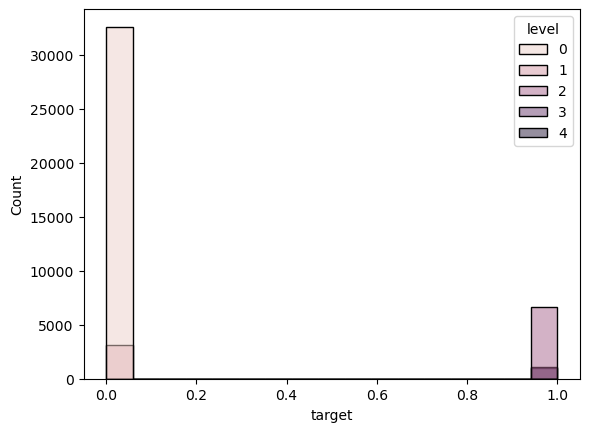

In [5]:
sns.histplot(data = train_df, x = 'target', hue = 'level')

In [6]:
t1 = train_df[train_df['target'] == 1]

<AxesSubplot:xlabel='level', ylabel='Count'>

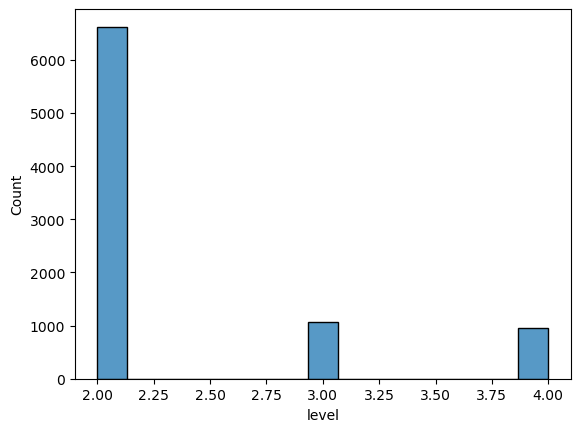

In [7]:
sns.histplot(data = train_df[train_df['target'] == 1], x = 'level')

In [8]:
print('Target count :')
print( f'Target | 0 | = {train_df[train_df.target == 0].shape[0]} samples' )
print( f'Target | 1 | = {train_df[train_df.target == 1].shape[0]} samples' )
print('-------------------------------')

print('Level count :')
print( f'Level | 0 | = {train_df[train_df.level == 0].shape[0]} samples' )
print( f'Level | 1 | = {train_df[train_df.level == 1].shape[0]} samples' )
print( f'Level | 2 | = {train_df[train_df.level == 2].shape[0]} samples' )
print( f'Level | 3 | = {train_df[train_df.level == 3].shape[0]} samples' )
print( f'Level | 4 | = {train_df[train_df.level == 4].shape[0]} samples' )
print('-------------------------------')
print(f'Total sample : {train_df.shape[0]}')

Target count :
Target | 0 | = 35706 samples
Target | 1 | = 8637 samples
-------------------------------
Level count :
Level | 0 | = 32575 samples
Level | 1 | = 3131 samples
Level | 2 | = 6626 samples
Level | 3 | = 1059 samples
Level | 4 | = 952 samples
-------------------------------
Total sample : 44343


In [9]:
fig_size = (12,12)

[841 245 644 229]


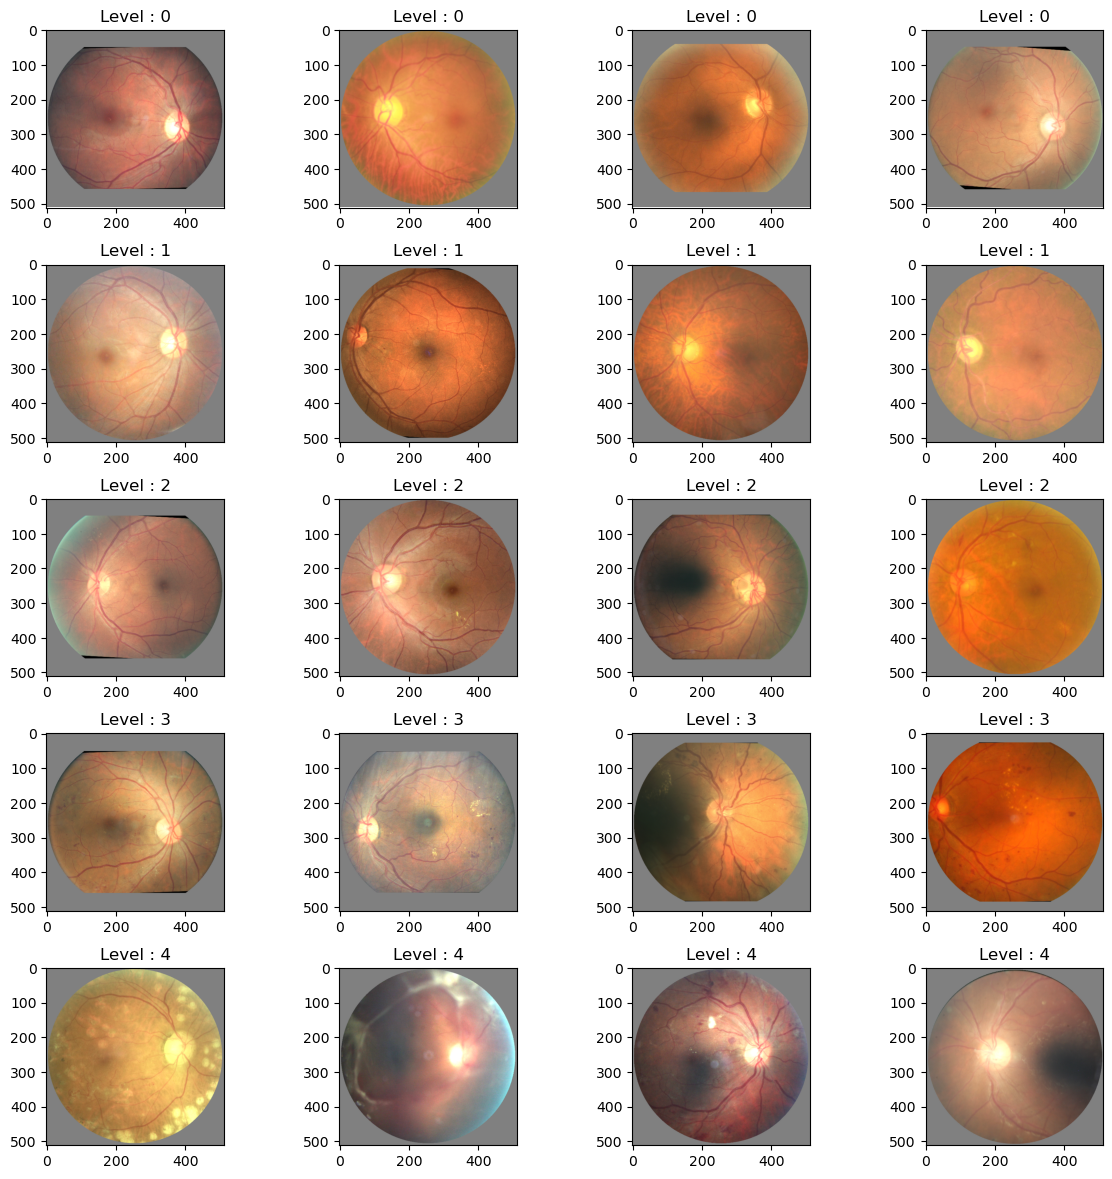

In [10]:
rand_arr = np.random.randint(0,952,4)
print(rand_arr)

fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = croped_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

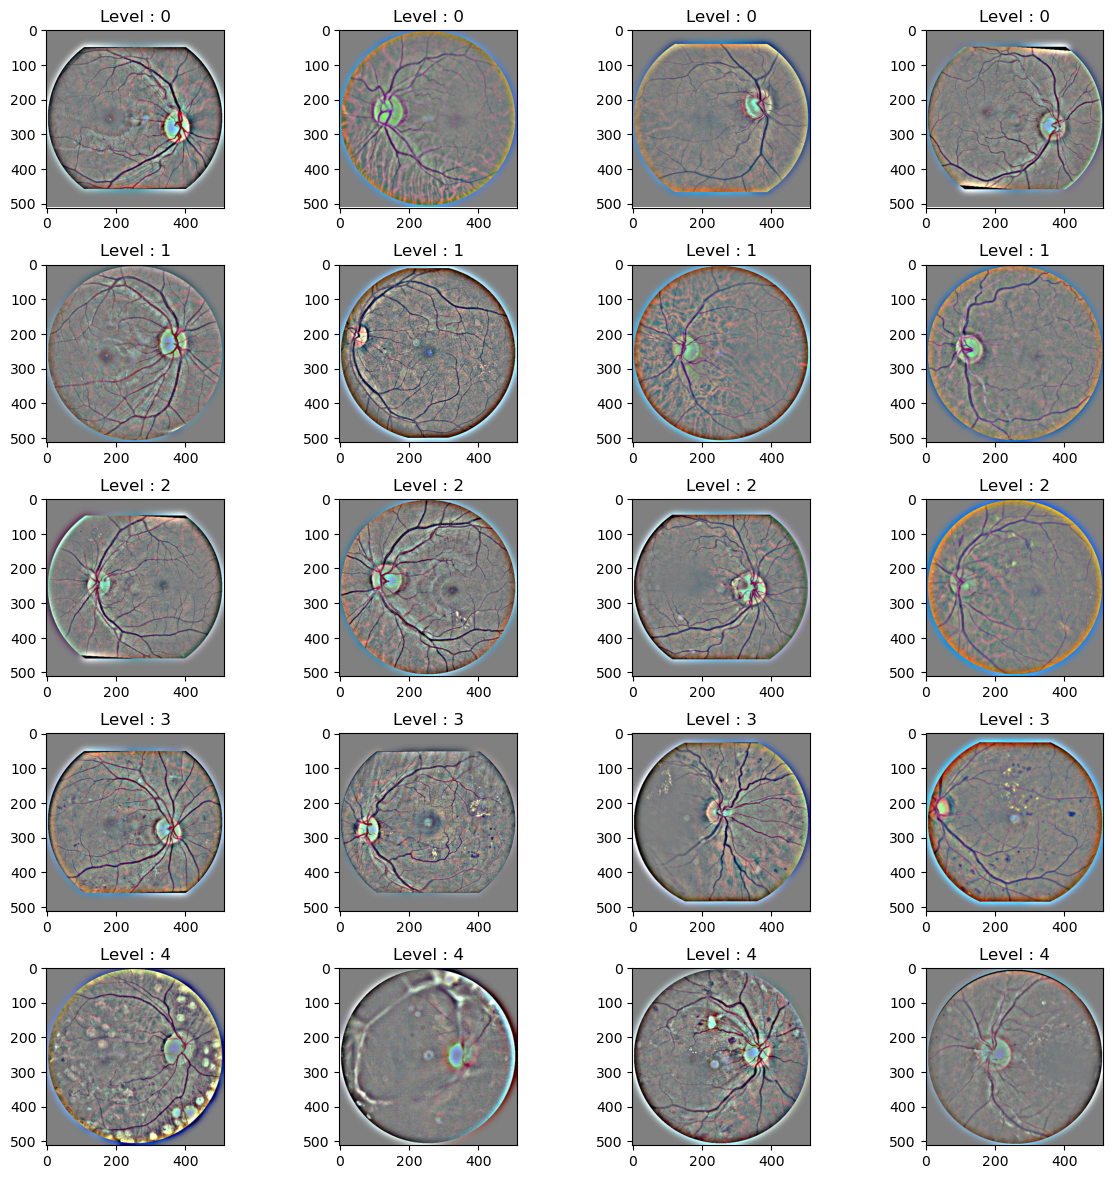

In [11]:

fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = contrast_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

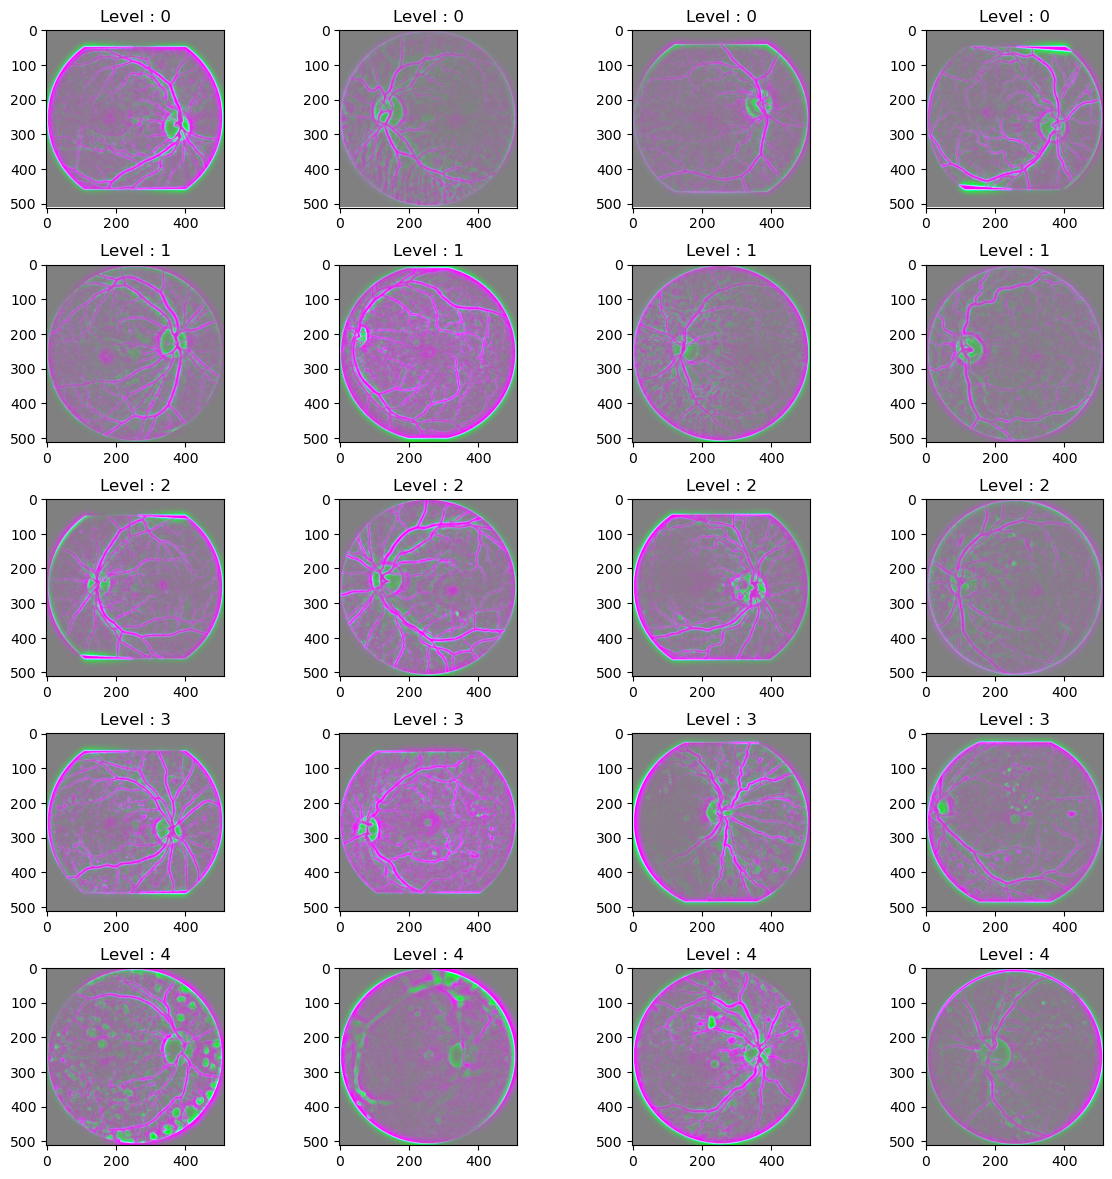

In [12]:
fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = enh_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

In [13]:
train_df

filename  level  target
0      im_80557.png      0       0
1      im_75804.png      0       0
2      im_54097.png      2       1
3      im_55937.png      0       0
4      im_63993.png      0       0
...             ...    ...     ...
44338  im_86503.png      0       0
44339  im_16881.png      0       0
44340  im_44521.png      1       0
44341  im_45835.png      0       0
44342  im_19961.png      0       0

[44343 rows x 3 columns]

# Lion Optimizer

In [14]:
import torch
from torch.optim.optimizer import Optimizer

# functions

def exists(val):
    return val is not None

# update functions

def update_fn(p, grad, exp_avg, lr, wd, beta1, beta2):
    # stepweight decay

    p.data.mul_(1 - lr * wd)

    # weight update

    update = exp_avg.clone().mul_(beta1).add(grad, alpha = 1 - beta1).sign_()
    p.add_(update, alpha = -lr)

    # decay the momentum running average coefficient

    exp_avg.mul_(beta2).add_(grad, alpha = 1 - beta2)

# class

class Lion(Optimizer):
    def __init__(
        self,
        params,
        lr: float = 1e-4,
        betas = (0.9, 0.99),
        weight_decay: float = 0.0,
    ):
        assert lr > 0.
        assert all([0. <= beta <= 1. for beta in betas])

        defaults = dict(
            lr = lr,
            betas = betas,
            weight_decay = weight_decay
        )

        super().__init__(params, defaults)

        self.update_fn = update_fn

    @torch.no_grad()
    def step(
        self,
        closure = None
    ):

        loss = None
        if exists(closure):
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in filter(lambda p: exists(p.grad), group['params']):

                grad, lr, wd, beta1, beta2, state = p.grad, group['lr'], group['weight_decay'], *group['betas'], self.state[p]

                # init state - exponential moving average of gradient values

                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']

                self.update_fn(
                    p,
                    grad,
                    exp_avg,
                    lr,
                    wd,
                    beta1,
                    beta2
                )

        return loss

# Feed batch on fly ------

In [15]:
class BatchFeeder:
    def __init__(self, df,img_size, batch_size, root, transform = None, one_hot = True, div_255 = False):
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.root = root
        self.transform = transform
        self.div_255 = div_255
        self.one_hot = one_hot

        
    def feed(self,ib):
        batchX = []
        batchY = []
        df = self.df[int(ib*self.batch_size):int( (ib*self.batch_size) + self.batch_size )]
        for i in df.iterrows():
            img_path = self.root + i[1][0]
            img_arr = cv2.imread(img_path)
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            img_arr = cv2.resize(img_arr,(self.img_size,self.img_size))
            
            if self.transform:
                img_arr = self.transform( image = img_arr )['image']
                
            if self.div_255:
                img_arr = self.arr_round(self.pic_div_255(img_arr))
            
            if self.one_hot:
                batchY.append(to_categorical(i[1][1],num_classes = 5))
            else:
                batchY.append(i[1][1])
            
            batchX.append(img_arr)
        return tch.from_numpy(np.array(batchX).astype(np.float32)),\
                tch.from_numpy(np.array(batchY))
    
    def pic_div_255(self,img):
        return img / 255
    
    def arr_round(self,img):
        return np.round(img,5)

In [16]:
transform = A.Compose([
#     A.Blur( p = 0.2 ),
    A.Flip( p = 0.2 ),
#    A.RandomBrightnessContrast(brightness_limit=0.45, contrast_limit=0.45,p=0.2),
    A.ShiftScaleRotate(p = 0.2),
#     A.ElasticTransform( p = 0.2),
    A.Transpose(p = 0.2),
#     A.GridDistortion(p = 0.2),
    A.HueSaturationValue(5,5,5,p = 0.2 ),
    A.CLAHE( p = 0.2 )], 
    #A.CoarseDropout( p = 0.2 ),],
    p = 1.0)

In [17]:
train = train_df[: int(train_df.shape[0] * 0.8) ]
test = train_df[int(train_df.shape[0] * 0.8): ]

# Modeling

In [18]:
processor = ConvNextImageProcessor.from_pretrained('facebook/convnext-tiny-224')
model = ConvNextForImageClassification.from_pretrained('facebook/convnext-tiny-224')

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
model.classifier = tch.nn.Sequential(
    tch.nn.Linear(768,1024),
    tch.nn.ReLU(),
    tch.nn.Linear(1024,train_df.level.nunique()),
    tch.nn.ReLU(),
)

##
model= tch.nn.DataParallel(model)
model = model.to(device)

In [21]:
(test.shape[0] * 0.022) / 30

6.503933333333333

In [22]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 10.6 MB/s eta 0:00:00


In [23]:
from torcheval.metrics.functional import multiclass_f1_score

In [24]:
def val_on_batch(model, img_size, batch_size, transform, criterion, size = 0.022):
    df = test[:int(test.shape[0] * size)]
    stepsE = df.shape[0] // batch_size
    print(stepsE)
    val_loss = 0
    val_acc = 0
    f1_val = 0
    for st in range(stepsE):
        model.eval()
        bfd_test = BatchFeeder(df,img_size,batch_size,enh_root,transform).feed(st)
        x_inp = processor(bfd_test[0],return_tensors="pt")
        y_inp = bfd_test[1].to(device)

        with tch.no_grad():
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
            f1_ = multiclass_f1_score(out.logits.argmax(1), y_inp.argmax(1),num_classes=5)
            
        f1_val += f1_.item() / stepsE
        val_loss += loss.item() / stepsE
        val_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
    
    return val_loss,val_acc / df.shape[0],f1_val

In [25]:
def train_model(model,img_size,ep,batch_size,criterion,optimizer,scheduler):
    
    stepsT = train.shape[0] // batch_size
    stepsE = test.shape[0] // batch_size
#     Xtrain.to(device)
#     Xtest.to(device)
#     Ytrain.to(device)
#     Ytest.to(device)
    best_val = 0
    for i in range(ep):
        print(f'Ep: {i+1}')
        
        train_loss = 0
        val_loss = 0
        
        train_acc = 0
        val_acc = 0
        
        train_f1 = 0
        val_f1 = 0
        ## Train
        for st in tqdm(range(stepsT)):
            model.train()
            # Prepare the Input
            bfd_train = BatchFeeder(train,img_size,batch_size,enh_root,transform).feed(st)
            
            x_inp = processor(bfd_train[0], return_tensors="pt")
            y_inp = bfd_train[1].to(device)
            
            optimizer.zero_grad()
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
            f1_ = multiclass_f1_score(out.logits.argmax(1), y_inp.argmax(1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() / stepsT
            train_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
            train_f1 += f1_.item() / stepsT
            
            if (st+1) % 100 == 0:
                print('Eval ---------------- Eval')
                ls,acc,f1 = val_on_batch(model, img_size, batch_size, transform, criterion)
                print(f'Loss: {ls:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}')
                tch.save(model,'/kaggle/working/checkpoint.pth')
                
                if acc > best_val:
                    tch.save(model,'/kaggle/working/checkpoint_hof.pth')
                    best_val = acc
            
#             if (train_acc / (batch_size * st)) > best_val:
# #                 print('Best val score saving model...')
#                 tch.save(model,f'checkpoint_hof.pth')
#                 best_val = (train_acc / (batch_size * st))
            
            scheduler.step()
        tch.cuda.empty_cache()
        
        
        ## Test
        for st in tqdm(range(stepsE)):
            model.eval()
            # Prepare the Input
            bfd_test = BatchFeeder(test,img_size,batch_size,enh_root,transform).feed(st)
            
            x_inp = processor(bfd_test[0],return_tensors="pt")
            y_inp = bfd_test[1].to(device)
            
            with tch.no_grad():
                out = model(**x_inp.to(device))
                loss = criterion(out.logits,y_inp)
            
            f1_ = multiclass_f1_score(out.logits.argmax(1), y_inp.argmax(1))
            val_f1 += f1_.item() / stepsE
            val_loss += loss.item() / stepsE
            val_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
            
        print(f'Train loss: {train_loss:.4f} | Train acc: {(train_acc / train.shape[0]):.4f}')
        print(f'Val loss: {val_loss:.4f} | Val acc: {(val_acc / test.shape[0]):.4f}')
        print(f'Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}')

In [26]:
criterion = tch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = tch.optim.Adam(model.parameters(), lr=1e-5)
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = tch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [27]:
train_model(model,224,5,30,criterion,optimizer,scheduler)

Ep: 1


  8%|▊         | 99/1182 [01:20<12:54,  1.40it/s]

Eval ---------------- Eval
6
Loss: 0.7516 | Acc: 0.7231 | F1: 0.7833


 17%|█▋        | 199/1182 [02:44<13:27,  1.22it/s]

Eval ---------------- Eval
6
Loss: 0.7511 | Acc: 0.7231 | F1: 0.7833


 25%|██▌       | 299/1182 [04:08<11:34,  1.27it/s]

Eval ---------------- Eval
6
Loss: 0.7368 | Acc: 0.7231 | F1: 0.7833


 34%|███▍      | 399/1182 [05:32<10:18,  1.27it/s]

Eval ---------------- Eval
6
Loss: 0.7549 | Acc: 0.7231 | F1: 0.7833


 42%|████▏     | 499/1182 [06:56<08:46,  1.30it/s]

Eval ---------------- Eval
6
Loss: 0.7407 | Acc: 0.7231 | F1: 0.7833


 51%|█████     | 599/1182 [08:20<07:30,  1.29it/s]

Eval ---------------- Eval
6
Loss: 0.7514 | Acc: 0.7231 | F1: 0.7833


 59%|█████▉    | 699/1182 [09:43<06:30,  1.24it/s]

Eval ---------------- Eval
6
Loss: 0.7454 | Acc: 0.7231 | F1: 0.7833


 68%|██████▊   | 799/1182 [11:12<05:11,  1.23it/s]

Eval ---------------- Eval
6
Loss: 0.7530 | Acc: 0.7231 | F1: 0.7833


 76%|███████▌  | 899/1182 [12:35<03:50,  1.23it/s]

Eval ---------------- Eval
6
Loss: 0.7362 | Acc: 0.7231 | F1: 0.7833


 85%|████████▍ | 999/1182 [14:00<02:27,  1.24it/s]

Eval ---------------- Eval
6
Loss: 0.7505 | Acc: 0.7231 | F1: 0.7833


 93%|█████████▎| 1099/1182 [15:23<01:07,  1.23it/s]

Eval ---------------- Eval
6
Loss: 0.7483 | Acc: 0.7231 | F1: 0.7833


100%|██████████| 295/295 [03:58<00:00,  1.24it/s]


Train loss: 0.8806 | Train acc: 0.7328
Val loss: 0.8664 | Val acc: 0.7360
Train F1: 0.7331 | Val F1: 0.7376
Ep: 2


  8%|▊         | 99/1182 [01:13<12:58,  1.39it/s]

Eval ---------------- Eval
6
Loss: 0.7489 | Acc: 0.7231 | F1: 0.7833


 17%|█▋        | 199/1182 [02:30<11:43,  1.40it/s]

Eval ---------------- Eval
6
Loss: 0.7512 | Acc: 0.7231 | F1: 0.7833


 25%|██▌       | 299/1182 [03:48<11:37,  1.27it/s]

Eval ---------------- Eval
6
Loss: 0.7616 | Acc: 0.7231 | F1: 0.7833


 34%|███▍      | 399/1182 [05:07<09:40,  1.35it/s]

Eval ---------------- Eval
6
Loss: 0.7617 | Acc: 0.7231 | F1: 0.7833


 42%|████▏     | 499/1182 [06:24<08:22,  1.36it/s]

Eval ---------------- Eval
6
Loss: 0.7565 | Acc: 0.7231 | F1: 0.7833


 51%|█████     | 599/1182 [07:46<07:33,  1.28it/s]

Eval ---------------- Eval
6
Loss: 0.7398 | Acc: 0.7231 | F1: 0.7833


 59%|█████▉    | 699/1182 [09:10<06:15,  1.28it/s]

Eval ---------------- Eval
6
Loss: 0.7410 | Acc: 0.7231 | F1: 0.7833


 68%|██████▊   | 799/1182 [10:34<05:03,  1.26it/s]

Eval ---------------- Eval
6
Loss: 0.7509 | Acc: 0.7231 | F1: 0.7833


 76%|███████▌  | 899/1182 [14:44<11:22,  2.41s/it]

Eval ---------------- Eval
6
Loss: 0.7392 | Acc: 0.7231 | F1: 0.7833


 85%|████████▍ | 999/1182 [17:54<03:27,  1.14s/it]

Eval ---------------- Eval
6
Loss: 0.7409 | Acc: 0.7231 | F1: 0.7833


 93%|█████████▎| 1099/1182 [19:34<01:10,  1.18it/s]

Eval ---------------- Eval
6
Loss: 0.7426 | Acc: 0.7231 | F1: 0.7833


100%|██████████| 295/295 [04:16<00:00,  1.15it/s]


Train loss: 0.8707 | Train acc: 0.7337
Val loss: 0.8658 | Val acc: 0.7360
Train F1: 0.7340 | Val F1: 0.7376
Ep: 3


  8%|▊         | 99/1182 [01:19<13:06,  1.38it/s]

Eval ---------------- Eval
6
Loss: 0.7498 | Acc: 0.7231 | F1: 0.7833


 17%|█▋        | 199/1182 [02:36<11:36,  1.41it/s]

Eval ---------------- Eval
6
Loss: 0.7410 | Acc: 0.7231 | F1: 0.7833


 25%|██▌       | 299/1182 [03:53<10:49,  1.36it/s]

Eval ---------------- Eval
6
Loss: 0.7459 | Acc: 0.7231 | F1: 0.7833


 34%|███▍      | 399/1182 [05:10<09:55,  1.31it/s]

Eval ---------------- Eval
6
Loss: 0.7469 | Acc: 0.7231 | F1: 0.7833


 42%|████▏     | 499/1182 [06:27<08:14,  1.38it/s]

Eval ---------------- Eval
6
Loss: 0.7468 | Acc: 0.7231 | F1: 0.7833


 51%|█████     | 599/1182 [07:43<07:08,  1.36it/s]

Eval ---------------- Eval
6
Loss: 0.7542 | Acc: 0.7231 | F1: 0.7833


 59%|█████▉    | 699/1182 [08:58<05:44,  1.40it/s]

Eval ---------------- Eval
6
Loss: 0.7462 | Acc: 0.7231 | F1: 0.7833


 68%|██████▊   | 799/1182 [10:14<05:02,  1.27it/s]

Eval ---------------- Eval
6
Loss: 0.7400 | Acc: 0.7231 | F1: 0.7833


 76%|███████▌  | 899/1182 [11:30<03:21,  1.41it/s]

Eval ---------------- Eval
6
Loss: 0.7471 | Acc: 0.7231 | F1: 0.7833


 85%|████████▍ | 999/1182 [12:46<02:14,  1.36it/s]

Eval ---------------- Eval
6
Loss: 0.7512 | Acc: 0.7231 | F1: 0.7833


 93%|█████████▎| 1099/1182 [14:03<01:00,  1.37it/s]

Eval ---------------- Eval
6
Loss: 0.7484 | Acc: 0.7231 | F1: 0.7833


100%|██████████| 295/295 [03:36<00:00,  1.36it/s]


Train loss: 0.8714 | Train acc: 0.7337
Val loss: 0.8661 | Val acc: 0.7360
Train F1: 0.7340 | Val F1: 0.7376
Ep: 4


  8%|▊         | 99/1182 [01:19<14:24,  1.25it/s]

Eval ---------------- Eval
6
Loss: 0.7527 | Acc: 0.7231 | F1: 0.7833


 17%|█▋        | 199/1182 [02:44<13:20,  1.23it/s]

Eval ---------------- Eval
6
Loss: 0.7342 | Acc: 0.7231 | F1: 0.7833


 25%|██▌       | 299/1182 [04:10<12:47,  1.15it/s]

Eval ---------------- Eval
6
Loss: 0.7516 | Acc: 0.7231 | F1: 0.7833


 34%|███▍      | 399/1182 [05:39<10:33,  1.24it/s]

Eval ---------------- Eval
6
Loss: 0.7497 | Acc: 0.7231 | F1: 0.7833


 42%|████▏     | 499/1182 [07:04<08:54,  1.28it/s]

Eval ---------------- Eval
6
Loss: 0.7327 | Acc: 0.7231 | F1: 0.7833


 51%|█████     | 599/1182 [08:29<07:48,  1.25it/s]

Eval ---------------- Eval
6
Loss: 0.7541 | Acc: 0.7231 | F1: 0.7833


 59%|█████▉    | 699/1182 [09:53<06:28,  1.24it/s]

Eval ---------------- Eval
6
Loss: 0.7462 | Acc: 0.7231 | F1: 0.7833


 68%|██████▊   | 799/1182 [11:16<05:16,  1.21it/s]

Eval ---------------- Eval
6
Loss: 0.7476 | Acc: 0.7231 | F1: 0.7833


 76%|███████▌  | 899/1182 [12:40<03:45,  1.26it/s]

Eval ---------------- Eval
6
Loss: 0.7445 | Acc: 0.7231 | F1: 0.7833


 85%|████████▍ | 999/1182 [14:05<02:26,  1.25it/s]

Eval ---------------- Eval
6
Loss: 0.7357 | Acc: 0.7231 | F1: 0.7833


 93%|█████████▎| 1099/1182 [15:29<01:08,  1.22it/s]

Eval ---------------- Eval
6
Loss: 0.7476 | Acc: 0.7231 | F1: 0.7833


100%|██████████| 295/295 [03:55<00:00,  1.25it/s]


Train loss: 0.8715 | Train acc: 0.7337
Val loss: 0.8674 | Val acc: 0.7360
Train F1: 0.7340 | Val F1: 0.7376
Ep: 5


  8%|▊         | 99/1182 [01:14<13:51,  1.30it/s]

Eval ---------------- Eval
6
Loss: 0.7384 | Acc: 0.7231 | F1: 0.7833


 17%|█▋        | 199/1182 [02:33<12:07,  1.35it/s]

Eval ---------------- Eval
6
Loss: 0.7481 | Acc: 0.7231 | F1: 0.7833


 25%|██▌       | 299/1182 [03:53<11:05,  1.33it/s]

Eval ---------------- Eval
6
Loss: 0.7509 | Acc: 0.7231 | F1: 0.7833


 34%|███▍      | 399/1182 [05:13<09:38,  1.35it/s]

Eval ---------------- Eval
6
Loss: 0.7404 | Acc: 0.7231 | F1: 0.7833


 42%|████▏     | 499/1182 [06:31<08:31,  1.33it/s]

Eval ---------------- Eval
6
Loss: 0.7481 | Acc: 0.7231 | F1: 0.7833


 51%|█████     | 599/1182 [07:49<07:02,  1.38it/s]

Eval ---------------- Eval
6
Loss: 0.7442 | Acc: 0.7231 | F1: 0.7833


 59%|█████▉    | 699/1182 [09:08<06:06,  1.32it/s]

Eval ---------------- Eval
6
Loss: 0.7504 | Acc: 0.7231 | F1: 0.7833


 68%|██████▊   | 799/1182 [10:27<04:45,  1.34it/s]

Eval ---------------- Eval
6
Loss: 0.7463 | Acc: 0.7231 | F1: 0.7833


 76%|███████▌  | 899/1182 [11:48<03:35,  1.31it/s]

Eval ---------------- Eval
6
Loss: 0.7419 | Acc: 0.7231 | F1: 0.7833


 85%|████████▍ | 999/1182 [13:06<02:20,  1.30it/s]

Eval ---------------- Eval
6
Loss: 0.7373 | Acc: 0.7231 | F1: 0.7833


 93%|█████████▎| 1099/1182 [14:25<01:08,  1.22it/s]

Eval ---------------- Eval
6
Loss: 0.7482 | Acc: 0.7231 | F1: 0.7833


100%|██████████| 295/295 [03:56<00:00,  1.25it/s]

Train loss: 0.8705 | Train acc: 0.7337
Val loss: 0.8664 | Val acc: 0.7360
Train F1: 0.7340 | Val F1: 0.7376


# GCS UTIL

In [28]:
# from google.cloud import storage
# storage_client = storage.Client(project='kaggle-383102')

# def create_bucket(bucket_name):
#     """Creates a new bucket. https://cloud.google.com/storage/docs/ """
#     bucket = storage_client.create_bucket(bucket_name)
#     print('Bucket {} created'.format(bucket_name.name))

# def upload_blob(bucket_name, source_file_name, destination_blob_name):
#     """Uploads a file to the bucket. https://cloud.google.com/storage/docs/ """
#     bucket = storage_client.get_bucket(bucket_name)
#     blob = bucket.blob(destination_blob_name)
#     blob.upload_from_filename(source_file_name)
#     print('File {} uploaded to {}.'.format(
#         source_file_name,
#         destination_blob_name))
    
# def list_blobs(bucket_name):
#     """Lists all the blobs in the bucket. https://cloud.google.com/storage/docs/"""
#     blobs = storage_client.list_blobs(bucket_name)
#     for blob in blobs:
#         print(blob.name)
        
# def download_to_kaggle(bucket_name,destination_directory,file_name):
#     """Takes the data from your GCS Bucket and puts it into the working directory of your Kaggle notebook"""
#     os.makedirs(destination_directory, exist_ok = True)
#     full_file_path = os.path.join(destination_directory, file_name)
#     blobs = storage_client.list_blobs(bucket_name)
#     for blob in blobs:
#         blob.download_to_filename(full_file_path)